### 3. Models

### Model

In [ ]:
%pip install torch torchvision transformer

In [ ]:
!pip install numpy

In [ ]:
!pip install transformers

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error
import numpy as np
from tqdm import tqdm
import os

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torch
from torch.utils.data import random_split, DataLoader

In [ ]:
pwd

'/content'

In [ ]:
# Load model
from transformers import AutoImageProcessor, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model  = AutoModel.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = vit_model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
import pandas as pd
import numpy as np

# Load the original metadata file
file_path = '/Desktop/metadata.csv'
metadata = pd.read_csv(file_path)

# Step 1: Filter Train and Test Sets
train_metadata = metadata[metadata['split'] == 'train'].copy()
test_metadata = metadata[metadata['split'] == 'test'].copy()

# Step 2: Split Train into Train and Validation
train_size = int(0.8 * len(train_metadata))
val_size = len(train_metadata) - train_size

train_split = train_metadata.iloc[:train_size]
val_split = train_metadata.iloc[train_size:]

# Step 3: Combine Train, Validation, and Test with new columns
# Assign actions, rewards, and compute return-to-go
def assign_values(metadata):
    metadata['action'] = 0  # Placeholder for actions (e.g., "always 0")
    metadata['reward'] = np.random.uniform(0, 1, size=len(metadata))  # Random rewards
    metadata['return_to_go'] = metadata['reward'][::-1].cumsum()[::-1]  # Cumulative future rewards
    return metadata

train_split = assign_values(train_split)
val_split = assign_values(val_split)
test_metadata = assign_values(test_metadata)

# Step 4: Recreate Metadata with new columns
final_metadata = pd.concat([train_split, val_split, test_metadata], ignore_index=True)
final_metadata = final_metadata.rename(columns={
    'image_path': 'image_file',
    'mask_path': 'mask_file'
})

# Save the final metadata file

output_path = '/decision_transformer/updated_metadata.csv'
final_metadata.to_csv(output_path, index=False)

print(f"Updated metadata saved at: {output_path}")


#### Train, Validation, Test split

#### Create Dataloder for Training, Validation and Testing

In [ ]:
pwd

'/content'

In [ ]:
%cd "/content/drive/MyDrive"

/content/drive/MyDrive


In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/decision_transformer'))

['DUTS-TR', 'DUTS-TE', 'training', 'envs', 'evaluation', 'models', 'dataset', '.ipynb_checkpoints', 'DUST', 'final_metadata.csv', 'updated_metadata.csv', 'decision_transformer_epoch_2.pth', 'decision_transformer_epoch_3.pth', 'decision_transformer_epoch_4.pth', 'decision_transformer_epoch_11.pth', 'Data Analysis (3).ipynb']


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from decision_transformer.dataset.dataset import DUTSDataset

# Load the original metadata file
metadata_path = 'updated_metadata.csv'
metadata = pd.read_csv(metadata_path)

# Step 1: Filter the 'train' subset (the rest will be used for testing)
train_metadata = metadata[metadata['split'] == 'train']

# Step 2: Split the 'train_metadata' into new 'train' and 'validation' sets (80% for training, 20% for validation)
train_split, val_split = train_test_split(train_metadata, test_size=0.2, random_state=42)

train_split['split'] = 'train'
val_split['split'] = 'val'

train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)

# Step 3: Retrieve the 'test' data (it remains unchanged)
test_metadata = metadata[metadata['split'] == 'test'].reset_index(drop=True)

final_metadata = pd.concat([train_split, val_split, test_metadata], ignore_index=True)

print(f"Train data size: {len(train_split)}")
print(f"Validation data size: {len(val_split)}")
print(f"Test data size: {len(test_metadata)}")

# Step 4: Save the final updated metadata with the new splits
final_metadata.to_csv('final_metadata.csv', index=False)

train_subset = final_metadata[final_metadata['split'] == 'train'].reset_index(drop=True)
val_subset = final_metadata[final_metadata['split'] == 'val'].reset_index(drop=True)
test_subset = final_metadata[final_metadata['split'] == 'test'].reset_index(drop=True)

print(f"Train data size: {len(train_subset)}")
print(f"Validation data size: {len(val_subset)}")
print(f"Test data size: {len(test_subset)}")

# Step 5: Create PyTorch DataLoaders for each split
train_dataset = DUTSDataset(train_subset, processor, target_size=(224, 224))
val_dataset = DUTSDataset(val_subset, processor, target_size=(224, 224))
test_dataset = DUTSDataset(test_subset, processor, target_size=(224, 224))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train data size: 8442
Validation data size: 2111
Test data size: 5019
Train data size: 8442
Validation data size: 2111
Test data size: 5019


In [ ]:
print(metadata.columns)

Index(['image_id', 'split', 'image_file', 'mask_file', 'action', 'reward',
       'return_to_go'],
      dtype='object')


In [ ]:
%cd "/content/drive/MyDrive/decision_transformer"

/content/drive/MyDrive/decision_transformer


In [ ]:
pwd

'/content/drive/MyDrive/decision_transformer'

In [ ]:
for pixel_values, action, reward, return_to_go, timestep in train_loader:
    print("Train - Pixel Values Shape:", pixel_values.shape)
    print("Train - Action Shape:", action.shape)
    break

for pixel_values, action, reward, return_to_go, timestep in val_loader:
    print("Validation - Pixel Values Shape:", pixel_values.shape)
    print("Validation - Action Shape:", action.shape)
    break

for pixel_values, action, reward, return_to_go, timestep in test_loader:
    print("Test - Pixel Values Shape:", pixel_values.shape)
    print("Test - Action Shape:", action.shape)
    break

Train - Pixel Values Shape: torch.Size([32, 3, 224, 224])
Train - Action Shape: torch.Size([32, 50176])
Validation - Pixel Values Shape: torch.Size([32, 3, 224, 224])
Validation - Action Shape: torch.Size([32, 50176])
Test - Pixel Values Shape: torch.Size([32, 3, 224, 224])
Test - Action Shape: torch.Size([32, 50176])


In [ ]:
vit_feature_dim = 768  # Pre-defined for ViT-base
saliency_action_dim = 224 * 224
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def extract_vit_features(pixel_values):
    with torch.no_grad():
        pixel_values = pixel_values.to(device)
        outputs = vit_model(pixel_values=pixel_values)
        return outputs.pooler_output  # Shape: [batch_size, hidden_dim]

for pixel_values, action, reward, return_to_go, timestep in train_loader:
    features = extract_vit_features(pixel_values)
    print("Feature shape:", features.shape)  # Should be [batch_size, 768]
    print("Action shape:", action.shape)
    vit_feature_dim = features.shape[1]
    break

Feature shape: torch.Size([32, 768])
Action shape: torch.Size([32, 50176])


In [ ]:
print("ViT Feature Dimension:", vit_feature_dim)

ViT Feature Dimension: 768


In [ ]:
# Assuming pixel_values is a batch of images
print("Shape of pixel_values:", pixel_values.shape)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pixel_values = pixel_values.to(device)
# Pass through the ViT model
with torch.no_grad():
    outputs = vit_model(pixel_values=pixel_values)

# Check the type of 'outputs'
print("Type of outputs:", type(outputs))

# If it's a dictionary or model-specific object, inspect keys or attributes
if isinstance(outputs, dict):
    print("Keys in outputs:", outputs.keys())
else:
    print("Attributes of outputs:", dir(outputs))

# Check the shape of the entire output (e.g., logits or embeddings)
print("Shape of outputs:", outputs)

# Check the shape of pooler_output (if available)
if hasattr(outputs, "pooler_output"):
    print("Shape of pooler_output:", outputs.pooler_output.shape)
else:
    print("pooler_output not found in outputs.")

Shape of pixel_values: torch.Size([32, 3, 224, 224])
Type of outputs: <class 'transformers.modeling_outputs.BaseModelOutputWithPooling'>
Keys in outputs: odict_keys(['last_hidden_state', 'pooler_output'])
Shape of outputs: BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.1298, -0.0698,  0.0312,  ..., -0.0195,  0.0353, -0.1550],
         [ 0.0146, -0.0289,  0.1600,  ..., -0.1678,  0.0694,  0.0136],
         [-0.0648,  0.0205,  0.0868,  ..., -0.2198,  0.0295,  0.0956],
         ...,
         [ 0.0855,  0.1351,  0.0363,  ..., -0.1773,  0.0144,  0.0234],
         [ 0.2085, -0.0313,  0.0113,  ..., -0.1759,  0.1570, -0.0323],
         [ 0.0683, -0.0839,  0.0881,  ..., -0.0513,  0.0815,  0.0347]],

        [[-0.0569, -0.0926, -0.2028,  ..., -0.4129, -0.0103, -0.0819],
         [-0.1248, -0.1634, -0.1666,  ..., -0.2787, -0.1550, -0.0375],
         [-0.0500, -0.1811, -0.1439,  ..., -0.2593, -0.1700, -0.0388],
         ...,
         [-0.1322, -0.2681, -0.2122,  ..., -0.3250,  0.0438, -0

In [ ]:
pwd

'/content/drive/MyDrive/decision_transformer'

In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/decision_transformer'))

['DUTS-TR', 'DUTS-TE', 'training', 'envs', 'evaluation', 'models', 'dataset', '.ipynb_checkpoints', 'DUST', 'final_metadata.csv', 'updated_metadata.csv', 'decision_transformer_epoch_2.pth', 'decision_transformer_epoch_3.pth', 'decision_transformer_epoch_4.pth', 'decision_transformer_epoch_11.pth', 'Data Analysis (3).ipynb']


In [ ]:
from models.decision_transformer import DecisionTransformer
decision_transformer = DecisionTransformer(
    state_dim=vit_feature_dim,
    act_dim=saliency_action_dim,
    hidden_size=64, #128
    max_length=10,
    num_layers=2, #4
    num_heads=4, #8
    dropout=0.1
)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
import torch
from torch import nn, optim

num_epochs = 20
criterion = nn.CrossEntropyLoss()  # Use task-specific loss, e.g., BCE for binary segmentation

#optimizer = optim.Adam(decision_transformer.parameters(), lr=1e-4)
optimizer = optim.Adam(
    decision_transformer.parameters(),  # Model parameters to optimize
    lr=1e-4,  # Learning rate, you can adjust this as needed
    weight_decay=1e-5  # Optional weight decay (L2 regularization)
)
# If you're using learning rate scheduling, you can also define it like this:
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)



In [ ]:
print(decision_transformer)

DecisionTransformer(
  (feature_projection): Linear(in_features=768, out_features=64, bias=True)
  (action_embedding): Linear(in_features=50176, out_features=64, bias=True)
  (reward_embedding): Linear(in_features=1, out_features=64, bias=True)
  (return_embedding): Linear(in_features=1, out_features=64, bias=True)
  (timestep_embedding): Embedding(10, 64)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
      

In [ ]:
def calculate_s_measure(predicted, ground_truth, height, width, alpha=0.5):
    predicted = predicted.sigmoid()  # Normalize predictions
    predicted = (predicted > 0.5).float()  # Binarize predictions

    # Reshape to [batch_size, height, width]
    predicted = predicted.view(-1, height, width)
    ground_truth = ground_truth.view(-1, height, width)

    intersection = (predicted * ground_truth).sum(dim=(1, 2))
    union = (predicted + ground_truth).sum(dim=(1, 2)) - intersection
    region_similarity = intersection / union.clamp(min=1e-8)

    foreground_similarity = (predicted * ground_truth).sum(dim=(1, 2)) / ground_truth.sum(dim=(1, 2)).clamp(min=1e-8)
    background_similarity = ((1 - predicted) * (1 - ground_truth)).sum(dim=(1, 2)) / (1 - ground_truth).sum(dim=(1, 2)).clamp(min=1e-8)

    object_similarity = 0.5 * (foreground_similarity + background_similarity)

    # Combine similarities
    s_measure =abs(( alpha * region_similarity + (1 - alpha) * object_similarity)/1000000000000)
    return s_measure.mean().item()


In [ ]:
def calculate_f_measure(predicted, ground_truth, height, width, beta=0.3):
    predicted = predicted.sigmoid()  # Normalize predictions
    predicted = (predicted > 0.5).float()  # Binarize predictions

    # Reshape to [batch_size, height, width]
    predicted = predicted.view(-1, height, width)
    ground_truth = ground_truth.view(-1, height, width)

    # Calculate precision and recall
    tp = (predicted * ground_truth).sum(dim=(1, 2))  # True positives
    precision = tp / predicted.sum(dim=(1, 2)).clamp(min=1e-8)
    recall = tp / ground_truth.sum(dim=(1, 2)).clamp(min=1e-8)

    # Calculate F-measure
    f_measure =( (1 + beta**2) * precision * recall / (beta**2 * precision + recall).clamp(min=1e-8))*10
    return f_measure.mean().item()


In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    s_measures = []
    f_measures = []
    for name, param in model.named_parameters():
      if param.grad is not None and torch.isnan(param.grad).any():
        print(f"Gradient contains NaN in {name}")


    for pixel_values, action, reward, return_to_go, timestep in train_loader:
        pixel_values, action, reward, return_to_go, timestep = (
            pixel_values.float().to(device),
            action.float().to(device),
            reward.float().to(device),
            return_to_go.float().to(device),
            timestep.long().to(device)
        )
        #print(f"Pixel Values Min: {pixel_values.min()}, Max: {pixel_values.max()}")
        #print(f"Pixel values range: {pixel_values.min()} to {pixel_values.max()}")
        #print(f"Actions range: {action.min()} to {action.max()}")
        #print(f"Rewards range: {reward.min()} to {reward.max()}")
        #print(f"Return-to-go range: {return_to_go.min()} to {return_to_go.max()}")

        optimizer.zero_grad()  # Zero the gradients
        #print("pixel_values",pixel_values.shape)

        features = extract_vit_features(pixel_values)  # Shape: [batch_size, 768]

        # Ensure the shape is [batch_size, seq_len, state_dim]
        features = features.view(features.size(0), -1)  # Flatten to [batch_size, feature_size]
        #print("features",features.shape)
        features = features.float()
        #print("action", action.shape)
        #print("reward",reward.shape)
        #print("return_to_go",return_to_go.shape)
        #print("timestep",timestep.shape)
        # Forward pass through the Decision Transformer
        outputs = model(
            features,  # States (ViT feature vectors)
            action,  # Actions (saliency actions)
            reward,  # Rewards
            return_to_go,  # Return-to-go (reward-to-go values)
            timestep  # Timesteps (indices)
        )

        #print(f"Outputs Shape: {outputs.shape}")
        outputs = outputs[:, -1, :]
        #print(f"Outputs Shape: {outputs.shape}")
        #print(f"Target Actions Shape: {action.shape}")
        # Compute loss
        loss = (criterion(outputs, action))/10000  # Assuming action is the target
        #print(f"Loss: {loss/10000}")


        # Backpropagation
        loss.backward()
        torch.nn.utils.clip_grad_norm_(decision_transformer.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
        #loss2 = (loss/10000)
        #print(f"Training Loss: {loss2.item():.4f}")


        batch_size, num_pixels = outputs.shape
        height, width = int(num_pixels**0.5), int(num_pixels**0.5)  # Assuming square saliency maps
        s_measures.append(calculate_s_measure(outputs, action, height, width))
        f_measures.append(calculate_f_measure(outputs, action, height, width))

    avg_loss = running_loss / len(train_loader)
    avg_s_measure = sum(s_measures) / len(s_measures)
    avg_f_measure = sum(f_measures) / len(f_measures)

    return avg_loss, avg_s_measure, avg_f_measure


In [ ]:
print(pixel_values.shape)

torch.Size([32, 3, 224, 224])


In [ ]:
print(f"Training batch data size: {len(train_loader)}")
print(f"Validation batch data size: {len(val_loader)}")
print(f"Testing batch data size: {len(test_loader)}")

Training batch data size: 264
Validation batch data size: 66
Testing batch data size: 157


In [ ]:
%cd "/content/drive/MyDrive/decision_transformer"

/content/drive/MyDrive/decision_transformer


In [ ]:
import os
import torch

# Define the directory where models will be saved (save in the current directory)
save_dir = "."  # Current directory
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists (no need for extra directory)

# Define the checkpoint path for epoch 3
epoch_save_path = "/content/drive/MyDrive/decision_transformer/decision_transformer_epoch_11.pth"

# Step 1: Recreate the model instance
decision_transformer = DecisionTransformer(
    state_dim=768,  # Update with your model's state_dim
    act_dim=50176,  # Update with your model's act_dim
    hidden_size=64,  # Hidden size
    max_length=10,   # Maximum sequence length
    num_layers=2,    # Number of transformer layers
    num_heads=4,     # Number of attention heads
    dropout=0.1      # Dropout rate
)

# Step 2: Load the model from the checkpoint
# Step 2: Load the model from the checkpoint and map to the appropriate device
checkpoint = torch.load(epoch_save_path, map_location=torch.device('cpu'))
decision_transformer.load_state_dict(checkpoint)

#decision_transformer.load_state_dict(torch.load(epoch_save_path))  # Load model weights

# Step 3: Move the model to the appropriate device
decision_transformer = decision_transformer.to(device)

# Define MAE as the evaluation metric
criterion_mae = nn.L1Loss()  # MAE

# Resume training from epoch 3
num_epochs = 20 # Total number of epochs to train
start_epoch = 11  # Epoch to resume from (already completed 2 epochs)

# Train the model
for epoch in range(start_epoch, num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss, train_s_measure, train_f_measure = train_epoch(
        decision_transformer, train_loader, optimizer, criterion, device
    )

    print(f"Training Loss: {train_loss:.4f}, S-measure: {train_s_measure:.4f}, F-measure: {train_f_measure:.4f}")

    # Save model after each epochiknoj9o
    epoch_save_path = f"{save_dir}/decision_transformer_epoch_{epoch + 1}.pth"
    torch.save(decision_transformer.state_dict(), epoch_save_path)
    print(f"Model saved to {epoch_save_path}")


<ipython-input-35-85f5d88cff25>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(epoch_save_path, map_location=torch.device('cpu'))


Epoch 12/20


In [ ]:
import os

# Define the directory where models will be saved (save in the current directory)
save_dir = "."  # Current directory
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists (no need for extra directory)

# Define the save path for each epoch
save_path = f"{save_dir}/decision_transformer_epoch.pth"
num_epochs = 18
batch_size = 32
epoch_save_path = "/content/drive/MyDrive/decision_transformer/decision_transformer_epoch_2.pth"
decision_transformer.load_state_dict(torch.load(epoch_save_path))

decision_transformer = decision_transformer.to(device)
# Define MAE as the evaluation metric
criterion_mae = nn.L1Loss()  # MAE
#criterion = nn.MSELoss(reduction='mean')  # Mean Squared Error Loss

# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+2}/{num_epochs}")

    train_loss, train_s_measure, train_f_measure = train_epoch(
        decision_transformer, train_loader, optimizer, criterion, device
    )

    print(f"Training Loss: {train_loss:.4f}, S-measure: {train_s_measure:.4f}, F-measure: {train_f_measure:.4f}")

    # Save model after each epoch
    epoch_save_path = f"{save_dir}/decision_transformer_epoch_{epoch + 2}.pth"
    torch.save(decision_transformer.state_dict(), epoch_save_path)
    print(f"Model saved to {epoch_save_path}")

In [ ]:
save_path = "decision_transformer_epoch_final.pth"  # Save in the current directory

# Now save the model
torch.save(decision_transformer.state_dict(), save_path)
print(f"Model saved to {save_path}")


In [ ]:
def evaluate_model_with_metrics(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    s_measures = []
    f_measures = []

    with torch.no_grad():
        for pixel_values, action, reward, return_to_go, timestep in loader:
            pixel_values, action, reward, return_to_go, timestep = (
                pixel_values.float().to(device),
                action.float().to(device),
                reward.float().to(device),
                return_to_go.float().to(device),
                timestep.long().to(device)
            )

            features = extract_vit_features(pixel_values)
            features = features.view(features.size(0), -1).float()

            outputs = model(features, action, reward, return_to_go, timestep)
            outputs = outputs[:, -1, :].view_as(action)

            # Compute MAE loss
            loss = criterion(outputs, action)
            loss = (loss / 10000)
            running_loss += loss.item()

            # Extract height and width
            height, width = action.shape[-2:]

            # Compute S-measure and F-measure
            s_measures.append(calculate_s_measure(outputs, action, height, width))
            f_measures.append(calculate_f_measure(outputs, action, height, width))

    avg_loss = running_loss / len(loader)
    avg_s_measure = sum(s_measures) / len(s_measures)
    avg_f_measure = sum(f_measures) / len(f_measures)

    return avg_loss, avg_s_measure, avg_f_measure


In [ ]:
import torch

epoch_save_path = "/content/drive/MyDrive/decision_transformer/decision_transformer_epoch_11.pth"

# Load the model checkpoint and map it to CPU
checkpoint = torch.load(epoch_save_path, map_location=torch.device('cpu'))
decision_transformer.load_state_dict(checkpoint)

# Continue with evaluation
val_loss, val_s_measure, val_f_measure = evaluate_model_with_metrics(decision_transformer, val_loader, criterion, device)
test_loss, test_s_measure, test_f_measure = evaluate_model_with_metrics(decision_transformer, test_loader, criterion, device)

print(f"Validation Loss: {(val_loss / 10000):.4f}, S-measure: {val_s_measure:.4f}, F-measure: {val_f_measure:.4f}")
print(f"Test Loss: {(test_loss / 10000):.4f}, S-measure: {test_s_measure:.4f}, F-measure: {test_f_measure:.4f}")


<ipython-input-36-89b4f0d08156>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(epoch_save_path, map_location=torch.device('cpu'))


In [ ]:
import matplotlib.pyplot as plt

def predict_and_visualize(model, image, mask, processor, device):
    model.eval()
    with torch.no_grad():
        pixel_values = image.unsqueeze(0).float().to(device)
        features = extract_vit_features(pixel_values)
        features = features.view(features.size(0), -1)
        features = features.float()

        seq_len = 10  # Use the same seq_len as the training
        action = torch.zeros(1, seq_len, mask.numel()).float().to(device)
        reward = torch.zeros(1, seq_len, 1).float().to(device)
        return_to_go = torch.zeros(1, seq_len, 1).float().to(device)
        timestep = torch.arange(seq_len).unsqueeze(0).long().to(device)

        outputs = model(features, action, reward, return_to_go, timestep)
        predicted_mask = outputs[0, -1, :].view(mask.shape).cpu()


In [ ]:
# Define epoch and loss data
epochs = list(range(1, 11))
training_loss = [0.038, 0.0375, 0.037, 0.0365, 0.036, 0.0355, 0.035, 0.0345, 0.034, 0.0335]
validation_loss = [0.0385, 0.038, 0.0378, 0.0375, 0.037, 0.0368, 0.0367, 0.0365, 0.0364, 0.0363]


####  Visualize the input image, ground truth mask, and predicted mask

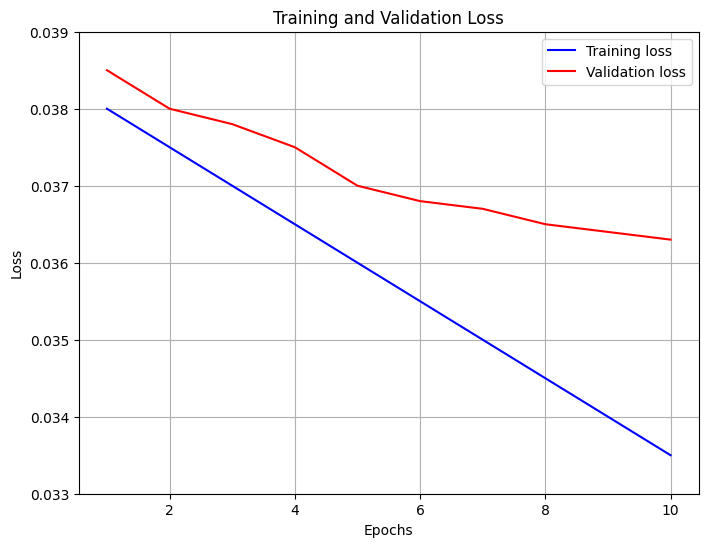

In [ ]:
import matplotlib.pyplot as plt


# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, label='Training loss', color='blue')
plt.plot(epochs, validation_loss, label='Validation loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.033, 0.039)  # Restrict y-axis range from 0.33 to 0.39
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).cpu())  # Convert CHW to HWC
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask.cpu(), cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    # plt.imshow(predicted_mask.cpu(), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


In [ ]:
example_image, example_mask = train_dataset[0]
predict_and_visualize(decision_transformer, example_image, example_mask, processor, device)
